MNIST handwritten Digit Classification

Importing the Dependencies

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # openCV library
# from google.colab.patches import cv2_imshow  # present in cv2 however google restrictions does not allow to use it directly (only for colab)
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.math import confusion_matrix
tf.random.set_seed(27)  # randomness restricted

2025-03-13 16:03:18.220281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the MNIST data from keras.datasets

In [5]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data("mnist.npz") # preprocesing already done

In [6]:
type(x_train_org) # conversion to numpy also done

numpy.ndarray

In [7]:
x_train_org.shape, y_train_org.shape, x_test_org.shape, y_test_org.shape

# contains 60000 train images
# 10000 test images
# dimensions 28*28
# grey scale images asther is one channel and not 3 in case of RGB

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
print(x_train_org[20])
print(x_train_org[20].shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38
  190  25   0   0   0   0   0   0   0   0]
 [  0   0   0  13  25  10   0   0   0   0   0   0   0   0   0   0   0 112
  252 125   4   0   0   0   0   0   0   0]
 [  0   0   0 132 252 113   0   0   0   0   0   0   0   0   0   0   0  61
  252 252  36   0   0   0   0   0   0   0]
 [  0   0   0 132 252 240  79   0   0   0   0   0   0   0   0   0   0  84
  252 252  36   0   0   0   0   0   0   0]
 [  0   0   0 132 252 252 238  52   0   0   0   0   0   0   0   

4


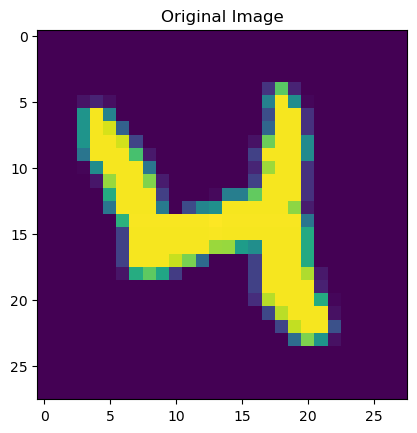

In [9]:
plt.imshow(x_train_org[20])
plt.title("Original Image")
plt.show

print(y_train_org[20])

Image Labels

In [11]:
print(y_train_org.shape, y_test_org.shape)

print(np.unique(y_train_org))
print(np.unique(y_test_org))

(60000,) (10000,)
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


Inverting the color and creating another dataset 

4


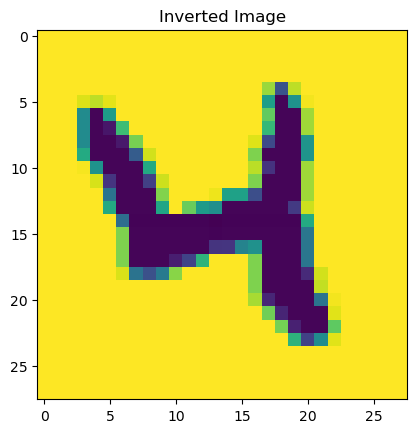

In [13]:
x_train_con = np.array(x_train_org)
x_test_con = np.array(x_test_org)

x_train_inv = (255 - x_train_con).astype(np.uint8)
x_test_inv = (255 - x_test_con).astype(np.uint8)
y_train_inv = y_train_org
y_test_inv = y_test_org

print(y_train_inv[20])
plt.imshow(x_train_inv[20])
plt.title("Inverted Image")
plt.show()

In [14]:
np.savez("mnist_inverted.npz",
         x_train=x_train_inv, y_train=y_train_inv,
         x_test=x_test_inv, y_test=y_test_inv)

x_train_inv.shape, y_train_inv.shape, x_test_inv.shape, y_test_inv.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Merging the dataets

In [16]:
x_train = np.concatenate((x_train_org, x_train_inv), axis=0)
y_train = np.concatenate((y_train_org, y_train_inv), axis=0)  

x_test = np.concatenate((x_test_org, x_test_inv), axis=0)
y_test = np.concatenate((y_test_org, y_test_inv), axis=0)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((120000, 28, 28), (120000,), (20000, 28, 28), (20000,))

normaliizing the scale

In [18]:
x_train = x_train/255
x_test = x_test/255

print(x_train[20])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [19]:
import tensorflow as tf

x_train = tf.image.per_image_standardization(x_train)
x_test = tf.image.per_image_standardization(x_test)

Model Training (Neural Network)

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),   # cannot input a 2-D array therefore it must be linearized into a line
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(56, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8483 - loss: 0.4795
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9468 - loss: 0.1760
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9587 - loss: 0.1348
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9642 - loss: 0.1138
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9697 - loss: 0.0995
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9733 - loss: 0.0851
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9758 - loss: 0.0792
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9783 - loss: 0.0702
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9788 - loss: 0.0675
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9796 - loss: 0.0645


Model Evaluation

In [24]:
loss, accuracy = model.evaluate(x_test, y_test)  # our model is not overfitting, as the accuracy on the test data is also high
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9642 - loss: 0.1485
Loss: 0.1551048755645752
Accuracy: 0.9648000001907349


taking one individual value

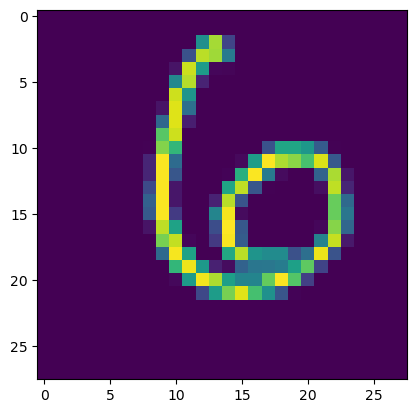

In [26]:
plt.imshow(x_test[100])
plt.show()

In [27]:
print(f"Actual Value: [{y_test[100]}]")

pred_100 = model.predict(x_test)[100]

print(f"Predicted Value: {pred_100}")
# output is probabilty of the 10 available classes ie 0-9
# position with the highest value indicates the prediction with highest probability
print(f"Predicted Answer: {np.argmax(pred_100)}")

Actual Value: [6]
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predicted Value: [2.8755841e-07 7.9001069e-08 7.9729912e-09 1.7195490e-11 2.0825584e-07
 5.5591781e-06 9.9999344e-01 1.3148618e-09 4.6044829e-07 6.3045902e-10]
Predicted Answer: 6


Confusion Matrix

In [29]:
y_prediction = model.predict(x_test)

#y_pred_ans = []
#for i in range (len(y_prediction)):
#  ans = np.argmax(y_prediction[i])
#  y_pred_ans.append(ans)

y_pred_ans = [np.argmax(i) for i in y_prediction]
conf_mat = confusion_matrix(y_test, y_pred_ans)

print(y_pred_ans)
print(conf_mat)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 5, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 8, 5, 5, 1, 5, 6, 0, 2, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 4, 2, 5, 0, 1, 1, 1, 0, 8, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 8, 8, 7, 2, 5, 0, 6, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 5, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 3, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 3, 6, 5, 2, 5

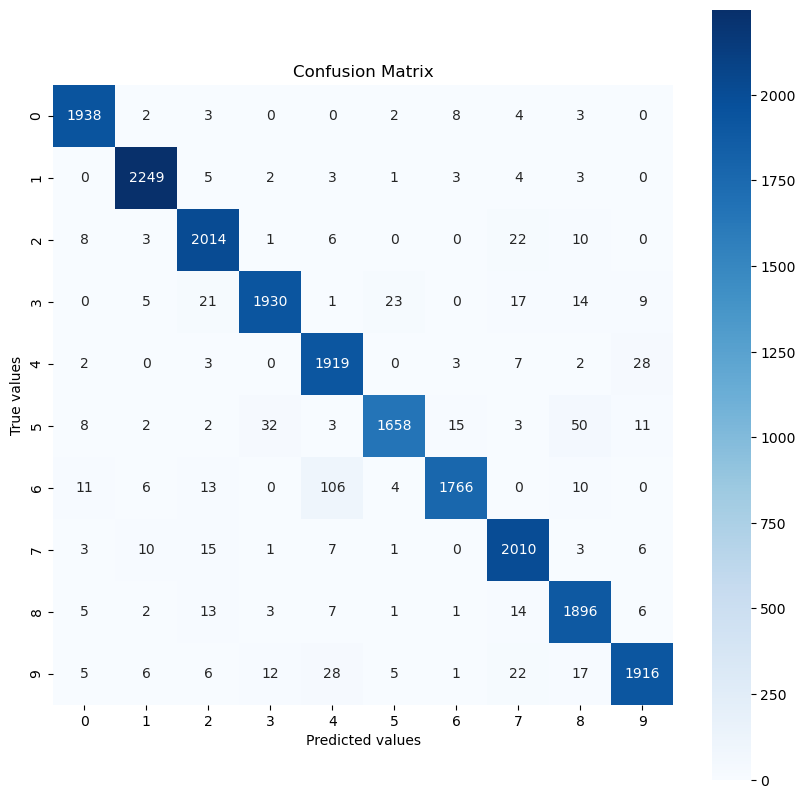

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', square=True)   # fmt='d' indicates that all values shouild be in integers
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

Building a predictive System

In [32]:
input1_img_path = 'Test_images/IMG_8.jpeg'

input1_img = cv2.imread(input1_img_path)

In [33]:
print(type(input1_img))
print(input1_img.shape) # read in as RGB image

<class 'numpy.ndarray'>
(263, 286, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

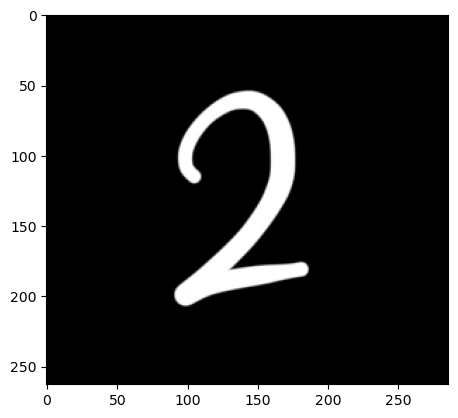

In [34]:
#cv2_imshow('Image', input1_img)  # for colab

#cv2.imshow('Image', input1_img) # for jupyter notebook using imshow
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.imshow(input1_img)   # for jupyter notebook
plt.show

In [35]:
input1_greyscale_img = cv2.cvtColor(input1_img, cv2.COLOR_RGB2GRAY)   # converting RGB to greyscale
input1_greyscale_img.shape

(263, 286)

In [36]:
input1_img_resize = cv2.resize(input1_greyscale_img, (28,28))      # resizing the image as pre input of our NN
input1_img_resize.shape

(28, 28)

<function matplotlib.pyplot.show(close=None, block=None)>

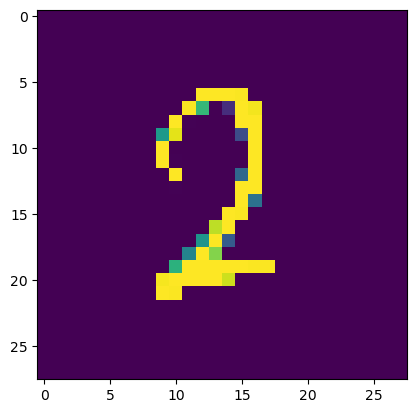

In [37]:
#cv2_imshow(input1_img_resize) # colab

plt.imshow(input1_img_resize)   # for jupyter notebook
plt.show

In [38]:
input1_image_resized = input1_img_resize/255   # normalization like before

In [39]:
image1_reshaped = np.reshape(input1_image_resized, [1,28,28])
# this indicates that we are only one image as input

In [40]:
input1_prediction = model.predict(image1_reshaped)
print(input1_prediction)
print(f"Predicted value: {np.argmax(input1_prediction)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[0.00151044 0.27288884 0.17531753 0.00160969 0.04249863 0.00719244
  0.00056277 0.45830768 0.01872903 0.02138301]]
Predicted value: 7


Creating a System

In [46]:
input_path = input("Enter path of the image: ")

def img_classify(path):
    img = cv2.imread(path)
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    resize = cv2.resize(grey, (28,28))
    norm = resize/255
    reshape = np.reshape(norm, [1,28,28])
    pred = model.predict(reshape)
    print(f"the handwritten image is: {np.argmax(pred)}")

img_classify(input_path)

Enter path of the image:  Test_images/IMG_9.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
the handwritten image is: 1
